In [1]:
%load_ext autoreload
%autoreload 2

In [98]:
%matplotlib inline
from cbrain.imports import *
from cbrain.data_generator import *
from keras.optimizers import *
from keras.layers import *
from keras.models import Model, Sequential
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

In [9]:
DATA_DIR = '/scratch/srasp/preprocessed_data/'
!ls {DATA_DIR}*10days*

/scratch/srasp/preprocessed_data/paper_nonorm_train_10days_features.nc
/scratch/srasp/preprocessed_data/paper_nonorm_train_10days_shuffle_features.nc
/scratch/srasp/preprocessed_data/paper_nonorm_train_10days_shuffle_targets.nc
/scratch/srasp/preprocessed_data/paper_nonorm_train_10days_targets.nc


In [19]:
train_fn = 'paper_nonorm_train_10days_shuffle'
norm_fn = 'paper_nonorm_train_fullyear_norm.nc'

In [263]:
bs=64

In [264]:
trn_gen_obj = DataGenerator(
    DATA_DIR, train_fn + '_features.nc', train_fn + '_targets.nc', bs, norm_fn,
    fsub='feature_means', fdiv='feature_stds', tmult='target_conv',shuffle=True,
)
trn_gen = trn_gen_obj.return_generator()

Generator will have 3932160 samples in 61440 batches
Features have shape 124; targets have shape 120


In [42]:
x, y = next(trn_gen)

In [43]:
x[0, 0]

0.27505362

In [44]:
x, y = next(trn_gen)
x[0, 0]

0.83762974

In [47]:
trn_gen = iter(trn_gen)

In [48]:
x, y = next(trn_gen)
x[0, 0]

-0.049327333

In [24]:
x.shape, y.shape

((128, 124), (128, 120))

In [25]:
x_shape, y_shape = 124, 120

In [165]:
def plot_samples(n=4):
    fake = gan.G.predict_on_batch(gan.noise(n))
    for i in range(n): plt.plot(fake[i])

## Basic GAN class


In [265]:
class GAN():
    def __init__(self):
        self.G, self.D, self.GD = None, None, None
        self.trn_dl, self.val_dl = None, None
        self.bs, self.n_batches, self.noise_shape = None, None, None
        self.epoch_counter = 0
        self.train_hist = defaultdict(list)
    
    def compile(self, opt=Adam(0.0002, 0.5)): 
        """Compile G and D and create GD"""
        # Compile individual models
        self.G.compile(opt, 'binary_crossentropy')   # Loss does not matter
        self.D.compile(opt, 'binary_crossentropy')
        
        # Create and compile combined model
        self.D.trainable = False
        inp_noise = Input(shape=(self.noise_shape,))
        self.GD = Model(inputs=inp_noise, outputs=self.D(self.G(inp_noise)))
        self.GD.compile(opt, 'binary_crossentropy')
    
    def train(self, n_epochs):
        """Training loop"""
        pbar = tqdm(total=n_epochs * self.n_batches)
        for e in range(self.epoch_counter, self.epoch_counter + n_epochs):
            losses = []
            for b in range(self.n_batches):
                pbar.update(1)
                losses.append(self.train_step())
            self.train_hist['trn_d_loss'].append(np.array(losses)[0].mean())
            self.train_hist['trn_g_loss'].append(np.array(losses)[1].mean())
            pbar_dict = OrderedDict(
                {k: v[-1] for k, v in self.train_hist.items()})
            pbar.set_postfix(pbar_dict)
            self.epoch_counter += 1
    
    def train_step(self):
        """Take one training step: 1) Train D on real/fake; 2) Train G
        Terminology: x (not yet) -> G -> y -> D -> label
        """
        # Step 1: Train discriminator
        d_loss = self.train_D()
        # Step 2: Train generator
        g_loss = self.train_G()
        return d_loss, g_loss
    
    def train_D(self):
        """Train discriminator and real/fake
        Labels: real = 1, fake = 0
        """
        # Load real and create fake images
        x_real, y_real = next(self.trn_dl)
        y_fake = self.G.predict_on_batch(self.noise(self.bs))
        
        # Concatenate
        y_concat = np.concatenate([y_real, y_fake])
        labels_concat = np.array([1]*self.bs + [0]*self.bs)
        
        # Train
        self.D.trainable = True
        return self.D.train_on_batch(y_concat, labels_concat)
    
    def train_G(self):
        """Train generator"""
        self.D.trainable = False
        return self.GD.train_on_batch(self.noise(self.bs*2), np.array([1]*self.bs*2))
        
    def noise(self, n_samples): return np.random.normal(size=(n_samples, self.noise_shape))

In [266]:
gan = GAN()

In [267]:
gan.bs = bs
gan.trn_dl = trn_gen
gan.n_batches = 100
gan.noise_shape = x_shape

In [268]:
gan.G = Sequential([
    Dense(256, input_shape=(x_shape,)),
    LeakyReLU(0.2),
    Dense(128),
    LeakyReLU(0.2),
    Dense(y_shape)
])

In [269]:
gan.D = Sequential([
    Dense(256, input_shape=(y_shape,)),
    LeakyReLU(0.2),
    Dense(128),
    LeakyReLU(0.2),
    Dense(1, activation='sigmoid')
])

In [270]:
gan.compile()

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

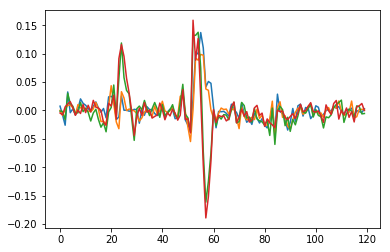

In [271]:
gan.train(20)
plot_samples()

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

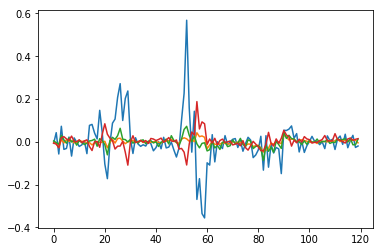

In [272]:
gan.train(20)
plot_samples()

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

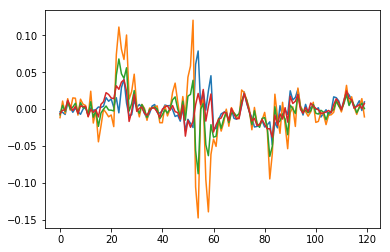

In [273]:
gan.train(20)
plot_samples()

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

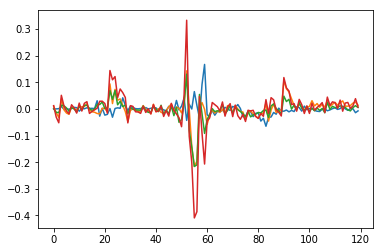

In [274]:
gan.train(20)
plot_samples()

In [ ]:
gan.train(2000)
plot_samples()

HBox(children=(IntProgress(value=0, max=200000), HTML(value='')))

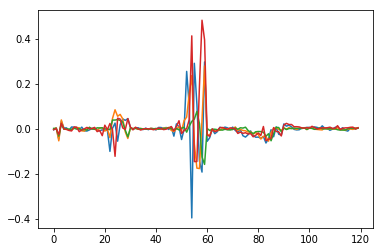

In [276]:
plot_samples()

In [277]:
fake = gan.G.predict_on_batch(gan.noise(10))

In [278]:
gan.D.predict_on_batch(fake)

array([[0.49360257],
       [0.49225372],
       [0.5062712 ],
       [0.485904  ],
       [0.4943093 ],
       [0.5326501 ],
       [0.5010083 ],
       [0.5130689 ],
       [0.50108445],
       [0.5011477 ]], dtype=float32)

In [279]:
gan.D.predict_on_batch(y)

array([[0.4838625 ],
       [0.43522894],
       [0.697242  ],
       [0.446893  ],
       [0.5092971 ],
       [0.51615626],
       [0.4791045 ],
       [0.46291298],
       [0.49702984],
       [0.477732  ],
       [0.49976015],
       [0.50491905],
       [0.5116008 ],
       [0.5055113 ],
       [0.49319854],
       [0.51041293],
       [0.5017489 ],
       [0.49758735],
       [0.5004768 ],
       [0.53089017],
       [0.48750547],
       [0.49286878],
       [0.49031648],
       [0.50879914],
       [0.5163678 ],
       [0.50786114],
       [0.5314129 ],
       [0.51106   ],
       [0.5226088 ],
       [0.51644564],
       [0.51549464],
       [0.50762254],
       [0.48680782],
       [0.499663  ],
       [0.49614188],
       [0.4983936 ],
       [0.48229116],
       [0.49690548],
       [0.4835307 ],
       [0.49472183],
       [0.50709605],
       [0.49829838],
       [0.50243   ],
       [0.49303502],
       [0.48215336],
       [0.49523908],
       [0.51022124],
       [0.481

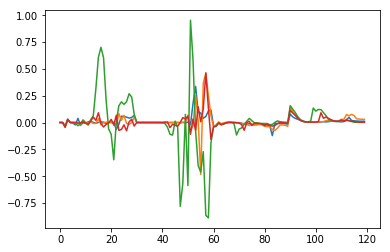

In [243]:
for i in range(4): plt.plot(y[i])